<a href="https://colab.research.google.com/github/w-dan/MATM/blob/main/MATM-code/data-analysis/bert_multitag(roberta_porsiacaso).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

This section includes installing required libraries and loading environment variables, also making sure GPUs are visible.

### Libraries

In [1]:
import importlib.util

def install_if_not_exists(package_name, no_deps=False):
    spec = importlib.util.find_spec(package_name)
    if spec is None:
        print(f"[+] Installing {package_name}...")
        if no_deps is False:
          !pip install {package_name} --quiet
        else:
          !pip install --no-deps {package_name} --quiet
    else:
        print(f"[-] {package_name} is already installed.")

In [2]:
# training
install_if_not_exists("torch", no_deps=False)
install_if_not_exists("transformers", no_deps=False)

# datasets
install_if_not_exists("datasets", no_deps=False)
install_if_not_exists("scikit-learn", no_deps=False)
install_if_not_exists("pandas", no_deps=False)
install_if_not_exists("pymongo", no_deps=False)

# other
install_if_not_exists("matplotlib", no_deps=False)
install_if_not_exists("python-dotenv", no_deps=False)

# wandb and deps
install_if_not_exists("sentry-sdk")
install_if_not_exists("setproctitle", no_deps=False)
# install_if_not_exists("wandb", no_deps=False)
install_if_not_exists("click", no_deps=False)
install_if_not_exists("docker-pycreds", no_deps=False)
install_if_not_exists("nltk", no_deps=False)

[-] torch is already installed.
[-] transformers is already installed.
[-] datasets is already installed.
[+] Installing scikit-learn...
[-] pandas is already installed.
[-] pymongo is already installed.
[-] matplotlib is already installed.
[+] Installing python-dotenv...
[+] Installing sentry-sdk...
[-] setproctitle is already installed.
[-] click is already installed.
[+] Installing docker-pycreds...
[-] nltk is already installed.


In [3]:
# core
import os, logging, time, torch, gc, re
from dotenv import load_dotenv
import numpy as np

# dataset
from datasets import Dataset
from pymongo import MongoClient
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader

# training
import torch
from transformers import(
    EarlyStoppingCallback,
    AdamW,
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    DistilBertConfig,
    BertTokenizer,
    BertForSequenceClassification,
    BertConfig,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    RobertaConfig,
    Trainer,
    TrainingArguments,
    AdamW,
    get_linear_schedule_with_warmup
)


# evaluation
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
import seaborn as sns

In [4]:
if torch.cuda.is_available():
    print("CUDA is available. GPUs detected:")

    # available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # GPU info
    for i in range(num_gpus):
        print(f"\nGPU {i}:")
        print(f"  Name: {torch.cuda.get_device_name(i)}")
        print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        print(f"  Compute Capability: {torch.cuda.get_device_capability(i)}")
        print(f"  Current Memory Allocated: {torch.cuda.memory_allocated(i) / 1e6:.2f} MB")
        print(f"  Current Memory Cached: {torch.cuda.memory_reserved(i) / 1e6:.2f} MB")
else:
    print("CUDA is not available. No GPUs detected.")

CUDA is available. GPUs detected:
Number of available GPUs: 2

GPU 0:
  Name: NVIDIA GeForce RTX 3090
  Total Memory: 25.44 GB
  Compute Capability: (8, 6)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB

GPU 1:
  Name: NVIDIA GeForce RTX 3090
  Total Memory: 25.44 GB
  Compute Capability: (8, 6)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB


### Environment variables and constants

In [5]:
load_dotenv(".env")
CONNECTION_STRING = os.getenv("CONNECTION_STRING")
TOKEN = os.getenv("HUGGINGFACE_TOKEN")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2"

In [6]:
DATABASE_NAME = "APTs"

GPU check (Docker container will sometimes lose GPU visibility)

In [7]:
!nvidia-smi

Fri Jul  5 17:16:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:18:00.0 Off |                  N/A |
| 74%   68C    P2             340W / 350W |   2742MiB / 24576MiB |     84%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Dataset loading


Initially, we will be building a dataset with raw text and tools. The dataset is stored in a MongoDB database, so we will have to fetch the data:

In [8]:
collection_name = "dataset"

In [9]:
client = MongoClient(CONNECTION_STRING)
db = client[DATABASE_NAME]

collection = db[collection_name]

In [10]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/dalgora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dalgora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def preprocess_corpus(text):
  """
  Preprocesses a given text by removing stopwords and setting lowercase.

  Args:
    text: The text to be preprocessed.

  Returns:
    The preprocessed text.
  """
  tokens = word_tokenize(text.lower())
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [token for token in tokens if token not in stop_words]

  preprocessed_text = ' '.join(filtered_tokens)

  return preprocessed_text

In [12]:
documents = collection.find()

data = []
for doc in documents:
  print(doc.keys())
  break

dict_keys(['_id', 'corpus', 'hash', 'techniques', 'tactics', 'procedures', 'IOCs', 'killchain_phase', 'apt_group'])


In [13]:
documents = collection.find()

data = []
for doc in documents:

    corpus = doc.get("corpus", "")
    tactics = doc.get("tactics", "")

    data.append({
        "corpus": preprocess_corpus(corpus),
        "tactics": tactics
    })

df = pd.DataFrame(data)

print(f"[+] Shape: {df.shape}")
df.head()

[+] Shape: (156, 2)


,corpus,tactics
0,decoding network data gh0st rat variant nccgro...,"[Execution, Persistence, Credential Access, Co..."
1,5www .prevailion.com /what-wicked-webs-we-unwe...,"[Credential Access, Defense Evasion]"
2,7www .mandiant.com /resources/blog/lightshift-...,"[Defense Evasion, Privilege Escalation, Execut..."
3,2015/11/24 russian financial cybercrime works ...,"[Credential Access, Exfiltration, Persistence]"
4,9/28/21 4:23 pm foggyw eb argeted nobelium mal...,"[Persistence, Credential Access, Command and C..."


In [14]:
df['tactics_length'] = df['tactics'].apply(len)

df['tactics_length'].value_counts()

tactics_length
5     53
6     32
7     13
4     12
3     12
8     11
9     10
11     6
10     4
12     2
2      1
Name: count, dtype: int64

In [15]:
tactics = df['tactics'].apply(pd.Series).stack().reset_index(drop=True).unique()
one_hot_df = pd.get_dummies(df['tactics'].apply(pd.Series).stack()).groupby(level=0).sum()
one_hot_df = one_hot_df.reindex(columns=tactics, fill_value=0)

df_one_hot_encoded = df.drop(columns=['tactics']).join(one_hot_df)

In [16]:
df_one_hot_encoded

,corpus,tactics_length,Execution,Persistence,Credential Access,Collection,Defense Evasion,Privilege Escalation,Exfiltration,Command and Control,Discovery,Initial Access,Resource Development,Lateral Movement,Impact,Reconnaissance
0,decoding network data gh0st rat variant nccgro...,4,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1,5www .prevailion.com /what-wicked-webs-we-unwe...,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,7www .mandiant.com /resources/blog/lightshift-...,3,1,0,0,0,1,1,0,0,0,0,0,0,0,0
3,2015/11/24 russian financial cybercrime works ...,3,0,1,1,0,0,0,1,0,0,0,0,0,0,0
4,9/28/21 4:23 pm foggyw eb argeted nobelium mal...,3,0,1,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,first release time 14:32 may 27 2015 updated t...,4,1,0,0,0,1,0,0,1,0,0,0,1,0,0
152,10/1/2019 helo innti attack scan lastline http...,6,1,1,0,0,1,0,0,1,0,1,0,0,0,1
153,9/9/2020 teamtnt activity tar gets eave scope ...,6,1,1,0,0,0,1,0,0,1,1,0,0,0,1
154,2stisc-gov-md.translate.goog /ro/stisc-atentie...,3,0,0,1,1,0,0,0,0,0,1,0,0,0,0


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch

In [18]:
os.environ["NCCL_IB_DISABLE"] = "1"
os.environ["NCCL_SHM_DISABLE"] = "1"

# Dataset preparation

A custom dataset class `CustomDataset` was created in order to be handled with data loaders (for Bert compatibility)

In [19]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

In [20]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

texts = df_one_hot_encoded['corpus'].tolist()
labels = df_one_hot_encoded.drop(columns=['corpus', 'tactics_length']).values

Small `TypeError` fix

In [21]:
def convert_to_float32(x):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        return np.array(x, dtype=np.float32)
    else:
        return np.float32(x)

Another small fix to ensure the array is 2D

In [22]:
labels_list = list(labels)

In [23]:
# making sure they are all the same length
max_length = max(len(label) for label in labels_list)
for i in range(len(labels_list)):
    if len(labels_list[i]) < max_length:
        labels_list[i] = np.pad(labels_list[i], (0, max_length - len(labels_list[i])), 'constant')

labels = np.vstack(labels_list) # stacking the labels into a 2D array

Generating the custom training and validation datasets

In [24]:
print(len(texts))
print(len(labels))

156
156


In [25]:
labels.shape

(156, 14)

In [26]:
# 1. split into training and temporary (which will be divided in 2) datasets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=33
)

# 2. split into validation and test (15% of total each)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=33
)


# 3. tokenize
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# 4. create the datasets
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

<Figure size 1000x600 with 0 Axes>

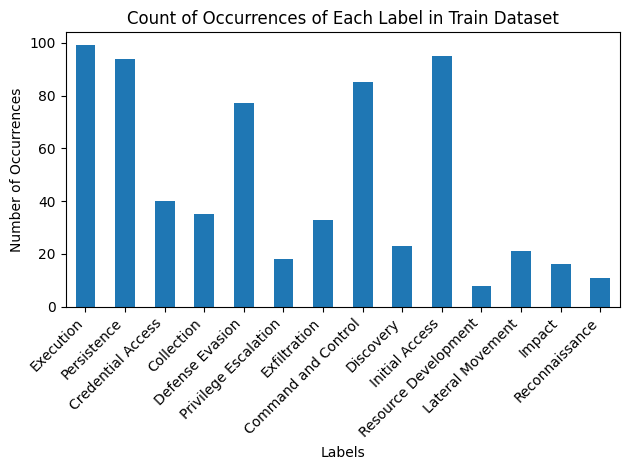

<Figure size 1000x600 with 0 Axes>

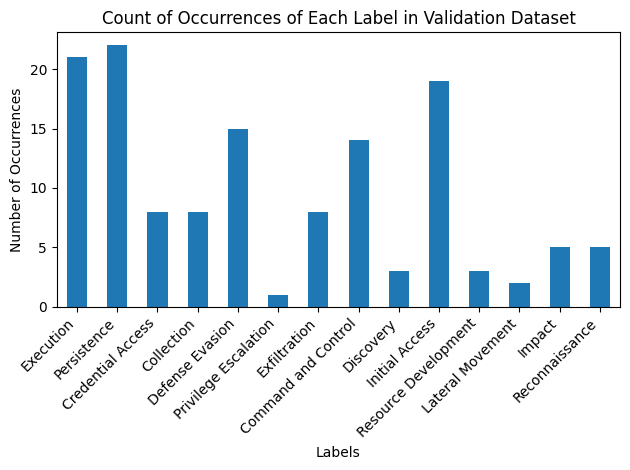

<Figure size 1000x600 with 0 Axes>

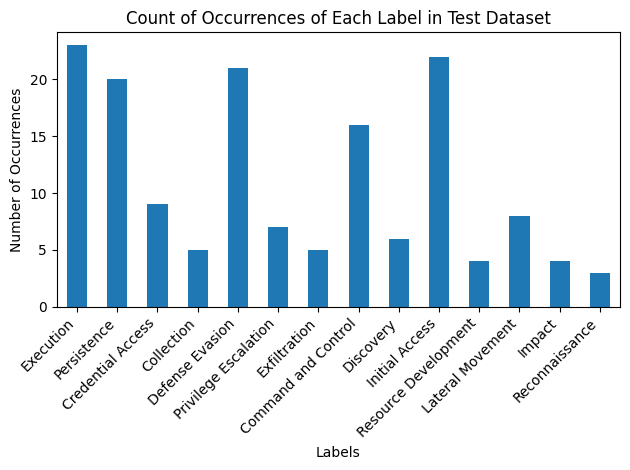

In [27]:
label_names = df_one_hot_encoded.columns[2:]

train_labels_df = pd.DataFrame(train_labels, columns=label_names)
val_labels_df = pd.DataFrame(val_labels, columns=label_names)
test_labels_df = pd.DataFrame(test_labels, columns=label_names)

def plot_label_occurrences_single(label_names, labels_df, dataset_name):
    label_counts = labels_df.sum()

    label_counts_df = pd.DataFrame(label_counts, columns=['Count'])

    plt.figure(figsize=(10, 6))
    label_counts_df.plot(kind='bar', legend=False)
    plt.xlabel('Labels')
    plt.ylabel('Number of Occurrences')
    plt.title(f'Count of Occurrences of Each Label in {dataset_name} Dataset')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_label_occurrences_single(label_names, train_labels_df, "Train")
plot_label_occurrences_single(label_names, val_labels_df, "Validation")
plot_label_occurrences_single(label_names, test_labels_df, "Test")


# Bert model and training

In [36]:
num_labels = labels.shape[1]
model = RobertaForSequenceClassification.from_pretrained(
    "FacebookAI/roberta-base",
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
data_collator = DataCollatorWithPadding(tokenizer)

In [38]:
model.config.hidden_dropout_prob = 0.2

In [39]:
weight_decay=1.8305098270915394e-05
learning_rate=1.3405098270915394e-05
num_train_epochs=100

training_args = TrainingArguments(
    num_train_epochs=num_train_epochs,       # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,            # batch size for evaluation
    warmup_steps=500,                        # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,               # strength of weight decay (formerly 0.01)
    logging_dir='./logs/',    # directory for storing logs
    logging_steps=10,
    eval_steps=10,
    save_steps=10,
    evaluation_strategy='epoch',
    learning_rate=learning_rate,
    output_dir='outputs_new'
)

optimizer = AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=len(train_dataset) * training_args.num_train_epochs
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, scheduler)
)

/home/dalgora/.local/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/dalgora/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
training_logs = trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,No log,0.697862
2,0.696400,0.697093
3,0.696500,0.695712
4,0.696500,0.693722
5,0.693600,0.691006
6,0.690200,0.687446
7,0.690200,0.682739
8,0.683800,0.675481
9,0.674600,0.662668
10,0.655800,0.638056


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

KeyboardInterrupt: 

In [ ]:
results = trainer.evaluate()
print(results)

# Evaluation

In [41]:
def predict(val_dataset):
    predictions = trainer.predict(val_dataset)
    pred_probs = torch.sigmoid(torch.tensor(predictions.predictions))
    pred_labels = (pred_probs >= 0.5).int().numpy()
    return pred_labels

def evaluate_predictions(true_labels, pred_labels):
    target_names = [f'Class {i}' for i in range(true_labels.shape[1])]

    print(classification_report(true_labels, pred_labels, target_names=target_names))

    cm = multilabel_confusion_matrix(true_labels, pred_labels)

    fig, axes = plt.subplots(nrows=cm.shape[0], figsize=(10, cm.shape[0] * 4))
    for i, ax in enumerate(axes):
        sns.heatmap(cm[i], annot=True, fmt='d', xticklabels=['Not ' + target_names[i], target_names[i]],
                    yticklabels=['Not ' + target_names[i], target_names[i]], ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Confusion Matrix for {target_names[i]}')

    plt.tight_layout()
    plt.show()

Epoch,Training Loss,Validation Loss
1,No log,0.697862
2,0.696400,0.697093
3,0.696500,0.695712
4,0.696500,0.693722
5,0.693600,0.691006
6,0.690200,0.687446
7,0.690200,0.682739
8,0.683800,0.675481
9,0.674600,0.662668
10,0.655800,0.638056


/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.91      1.00      0.95        21
     Class 1       0.96      1.00      0.98        22
     Class 2       0.50      0.50      0.50         8
     Class 3       0.00      0.00      0.00         8
     Class 4       0.65      1.00      0.79        15
     Class 5       0.00      0.00      0.00         1
     Class 6       0.50      0.12      0.20         8
     Class 7       0.61      1.00      0.76        14
     Class 8       0.00      0.00      0.00         3
     Class 9       0.83      1.00      0.90        19
    Class 10       0.00      0.00      0.00         3
    Class 11       0.00      0.00      0.00         2
    Class 12       0.00      0.00      0.00         5
    Class 13       0.00      0.00      0.00         5

   micro avg       0.76      0.72      0.74       134
   macro avg       0.35      0.40      0.36       134
weighted avg       0.61      0.72      0.65       134
 samples avg       0.76   

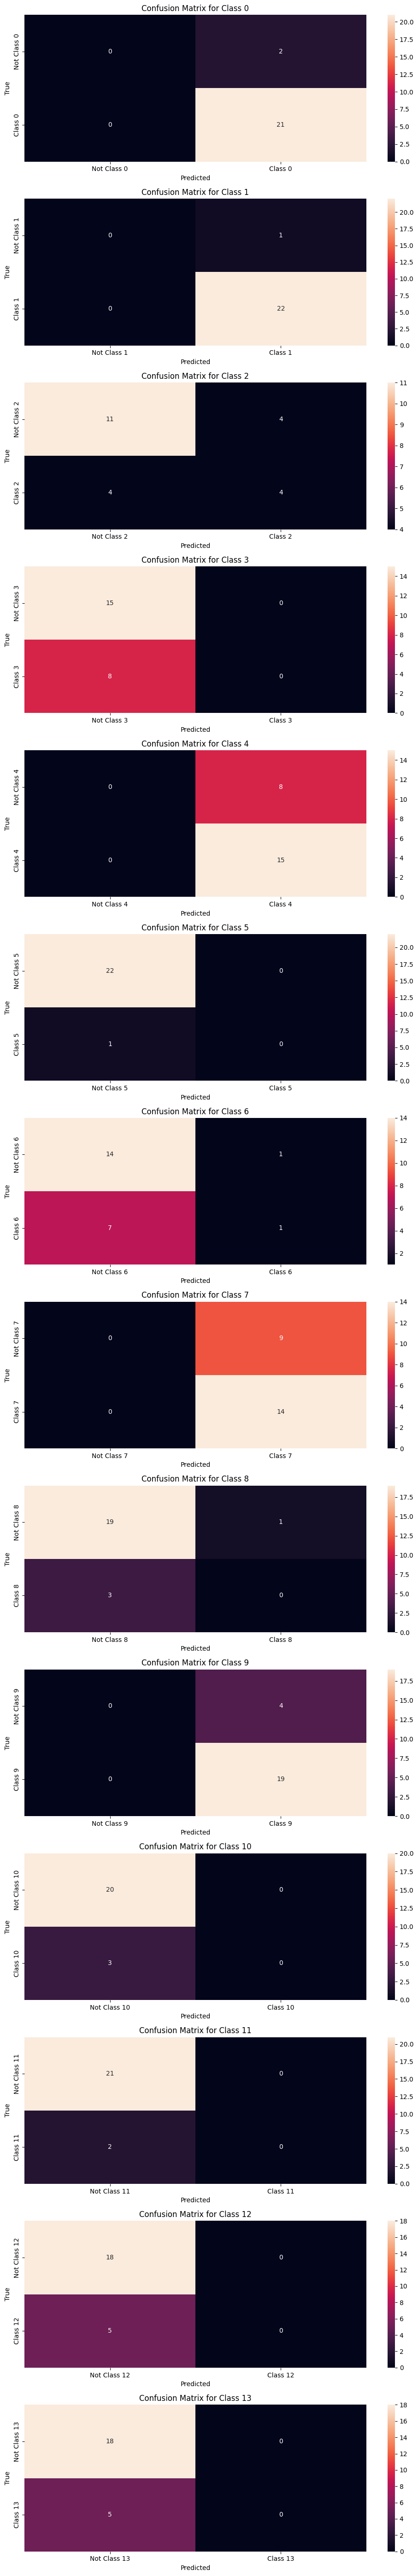

In [42]:
pred_labels = predict(val_dataset)
evaluate_predictions(val_labels, pred_labels)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,No log,0.697862
2,0.696400,0.697093
3,0.696500,0.695712
4,0.696500,0.693722
5,0.693600,0.691006
6,0.690200,0.687446
7,0.690200,0.682739
8,0.683800,0.675481
9,0.674600,0.662668
10,0.655800,0.638056


/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98        23
     Class 1       0.83      1.00      0.91        20
     Class 2       1.00      0.33      0.50         9
     Class 3       0.00      0.00      0.00         5
     Class 4       0.88      1.00      0.93        21
     Class 5       0.00      0.00      0.00         7
     Class 6       0.00      0.00      0.00         5
     Class 7       0.67      1.00      0.80        16
     Class 8       0.00      0.00      0.00         6
     Class 9       0.92      1.00      0.96        22
    Class 10       0.00      0.00      0.00         4
    Class 11       0.00      0.00      0.00         8
    Class 12       0.00      0.00      0.00         4
    Class 13       0.00      0.00      0.00         3

   micro avg       0.85      0.69      0.76       153
   macro avg       0.38      0.38      0.36       153
weighted avg       0.63      0.69      0.64       153
 samples avg       0.85   

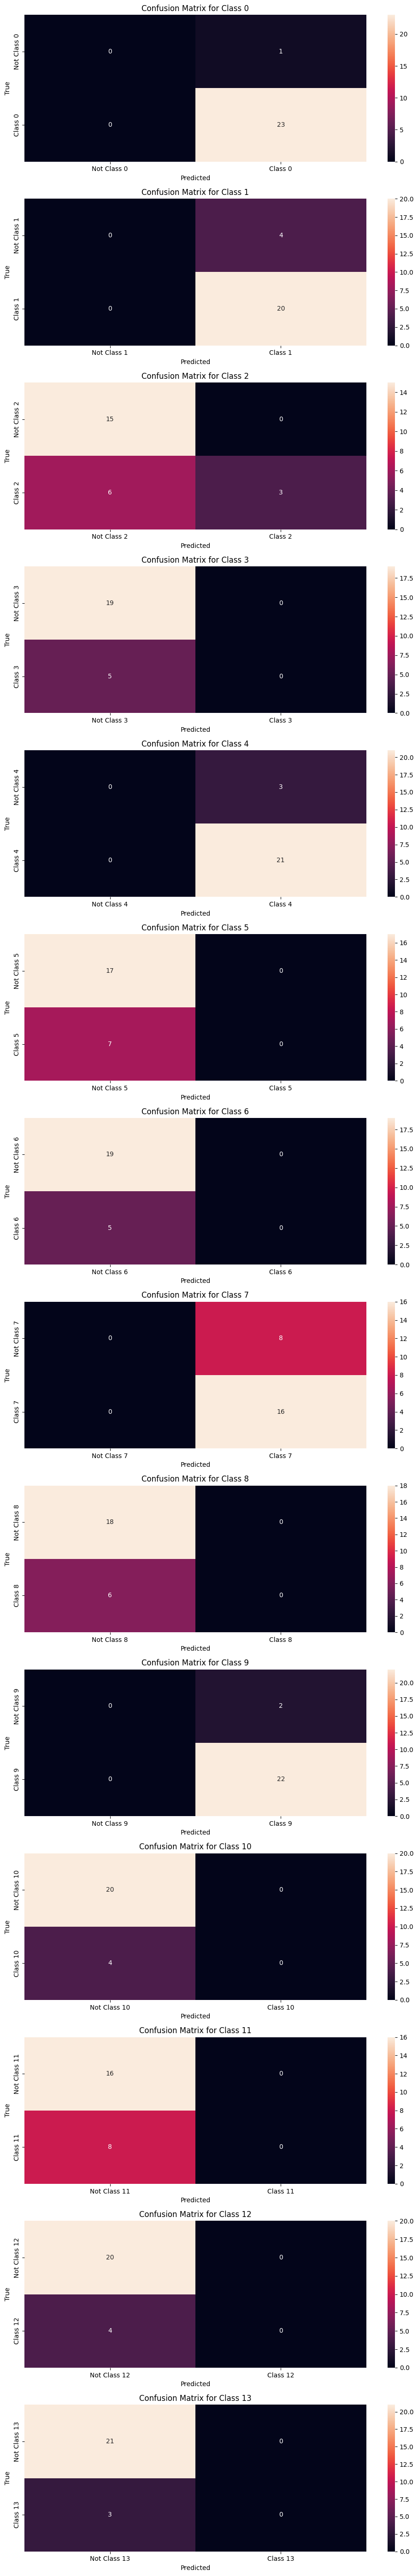

In [43]:
pred_labels_test = predict(test_dataset)
evaluate_predictions(test_labels, pred_labels_test)

In [44]:
training_logs

NameError: name 'training_logs' is not defined

In [ ]:
def evaluate_predictions_single_matrix(true_labels, pred_labels):
    target_names = [f'Class {i}' for i in range(true_labels.shape[1])]

    print(classification_report(true_labels, pred_labels, target_names=target_names))

    true_labels_flat = true_labels.flatten()
    pred_labels_flat = pred_labels.flatten()

    cm = confusion_matrix(true_labels_flat, pred_labels_flat)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Predicted', 'Predicted'],
                yticklabels=['Not True', 'True'], cmap='viridis')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Test evaluation (single confusion matrix)

In [ ]:
evaluate_predictions_single_matrix(test_labels, pred_labels_test)

Validation (single confusion matrix)

In [ ]:
evaluate_predictions_single_matrix(val_labels, pred_labels)

In [ ]:

def save_model(model, tokenizer, output_dir):
    """
    Saves the BERT model and tokenizer.

    Parameters:
    model (transformers.PreTrainedModel): The trained BERT model.
    tokenizer (transformers.PreTrainedTokenizer): The tokenizer associated with the model.
    output_dir (str): The directory where the model and tokenizer will be saved.

    Returns:
    None
    """
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"Model and tokenizer saved in {output_dir}")

In [ ]:
# output_dir = './bert_exp25'
# save_model(model, tokenizer, output_dir)

# Testing with a different dataset (blackberry)

In [45]:
from bert_utils import *

In [46]:
blackberry_dataset = fetch_and_preprocess_data(DATABASE_NAME, "dataset", CONNECTION_STRING, preprocess=True,
                                               field_to_get="tactics", include_tactics=True)

[nltk_data] Downloading package punkt to /home/dalgora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dalgora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Shape: (156, 2)
                                              corpus  \
0  decoding network data gh0st rat variant nccgro...   
1  5www .prevailion.com /what-wicked-webs-we-unwe...   
2  7www .mandiant.com /resources/blog/lightshift-...   
3  2015/11/24 russian financial cybercrime works ...   
4  9/28/21 4:23 pm foggyw eb argeted nobelium mal...   

                                             tactics  
0  [Execution, Persistence, Credential Access, Co...  
1               [Credential Access, Defense Evasion]  
2  [Defense Evasion, Privilege Escalation, Execut...  
3     [Credential Access, Exfiltration, Persistence]  
4  [Persistence, Credential Access, Command and C...  


In [47]:
bb_tactics = blackberry_dataset['tactics'].apply(pd.Series).stack().reset_index(drop=True).unique()
one_hot_df = pd.get_dummies(blackberry_dataset['tactics'].apply(pd.Series).stack()).groupby(level=0).sum()
one_hot_df = one_hot_df.reindex(columns=bb_tactics, fill_value=0)

bb_one_hot_encoded = blackberry_dataset.drop(columns=['tactics']).join(one_hot_df)
bb_one_hot_encoded.dropna(how='any', inplace=True)

bb_texts = bb_one_hot_encoded['corpus'].tolist()
bb_labels = bb_one_hot_encoded.drop(columns=['corpus']).values

In [48]:
"""output_dir = './bert_exp25'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model = BertForSequenceClassification.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[+] Model in device: {device}")


model.to(device)"""

'output_dir = \'./bert_exp25\'\ntokenizer = BertTokenizer.from_pretrained(output_dir)\nmodel = BertForSequenceClassification.from_pretrained(output_dir)\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nprint(f"[+] Model in device: {device}")\n\n\nmodel.to(device)'

In [49]:
sorted_labels = df_one_hot_encoded.columns[2:]
sorted_labels

Index(['Execution', 'Persistence', 'Credential Access', 'Collection',
       'Defense Evasion', 'Privilege Escalation', 'Exfiltration',
       'Command and Control', 'Discovery', 'Initial Access',
       'Resource Development', 'Lateral Movement', 'Impact', 'Reconnaissance'],
      dtype='object')

In [50]:
bb_encodings = tokenizer(list(bb_texts), truncation=True, padding=True)

In [51]:
bb_dataset = CustomDataset(bb_encodings, bb_labels)

## Evaluate on blackberry reports

In [52]:
def perform_inference(val_dataset):
    model.eval()
    dataloader = DataLoader(val_dataset, batch_size=8)
    pred_probs_list = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits
            pred_probs = torch.sigmoid(logits)
            pred_probs_list.append(pred_probs.cpu())

    pred_probs = torch.cat(pred_probs_list, dim=0)
    pred_labels = (pred_probs >= 0.5).int().numpy()
    return pred_labels

def evaluate_inference(true_labels, pred_labels):
    target_names = one_hot_df.columns

    print(classification_report(true_labels, pred_labels, target_names=target_names))
    cm = multilabel_confusion_matrix(true_labels, pred_labels)

    fig, axes = plt.subplots(nrows=cm.shape[0], figsize=(10, cm.shape[0] * 4))
    for i, ax in enumerate(axes):
        sns.heatmap(cm[i], annot=True, fmt='d', xticklabels=['Not ' + target_names[i], target_names[i]],
                    yticklabels=['Not ' + target_names[i], target_names[i]], ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Confusion Matrix for {target_names[i]}')

    plt.tight_layout()
    plt.show()


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[+] Model in device: {device}")

[+] Model in device: cuda


/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                      precision    recall  f1-score   support

           Execution       0.92      1.00      0.96       143
         Persistence       0.87      1.00      0.93       136
   Credential Access       0.74      0.40      0.52        57
          Collection       0.00      0.00      0.00        48
     Defense Evasion       0.73      1.00      0.85       113
Privilege Escalation       0.00      0.00      0.00        26
        Exfiltration       0.73      0.17      0.28        46
 Command and Control       0.74      1.00      0.85       115
           Discovery       0.75      0.09      0.17        32
      Initial Access       0.87      1.00      0.93       136
Resource Development       0.00      0.00      0.00        15
    Lateral Movement       1.00      0.06      0.12        31
              Impact       1.00      0.28      0.44        25
      Reconnaissance       0.00      0.00      0.00        19

           micro avg       0.82      0.73      0.77       942
      

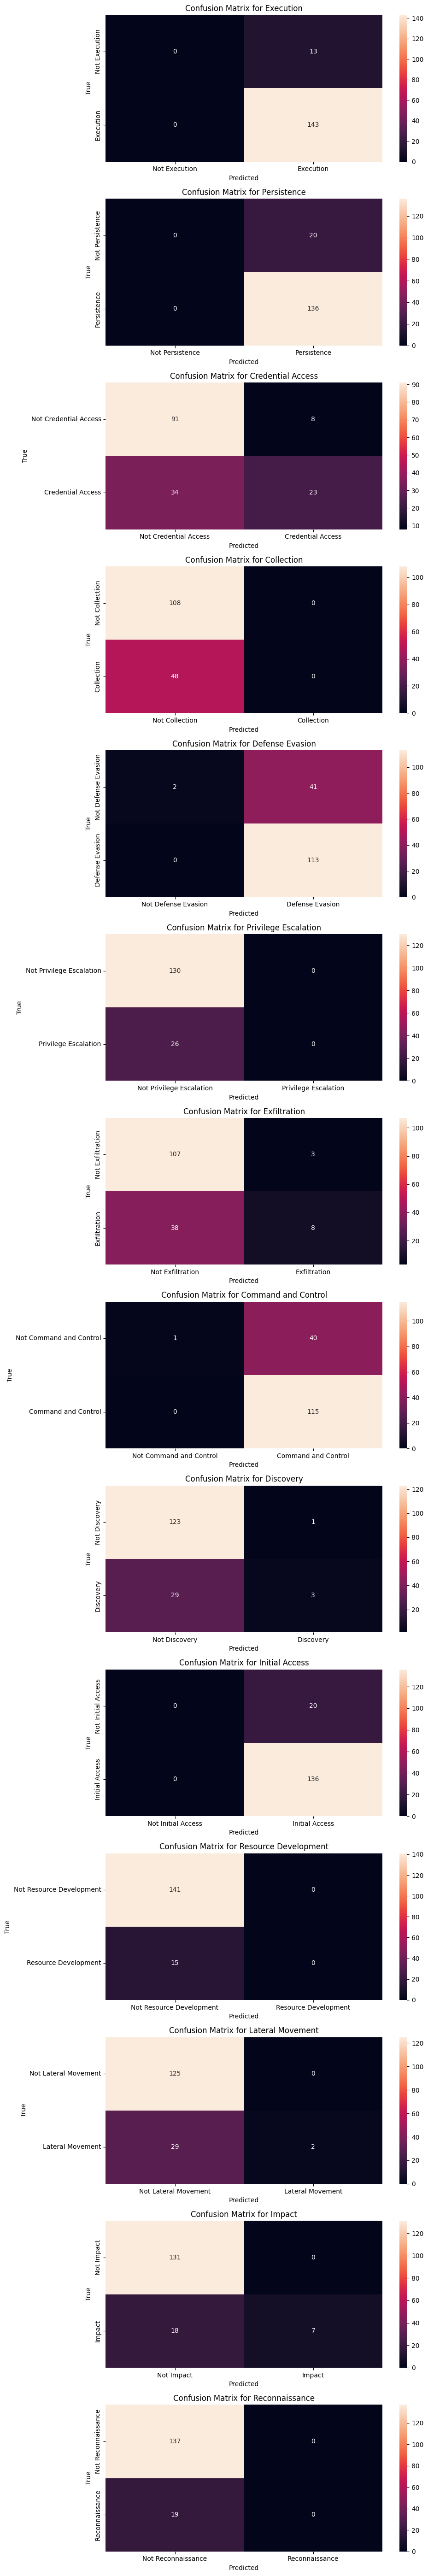

In [54]:
pred_labels = perform_inference(bb_dataset)
evaluate_inference(bb_labels, pred_labels)